# ACTIVIDAD 4

## GRUPO 2 - Carlos Gonzalez Van Liempt y Álvaro Farreny Boixader

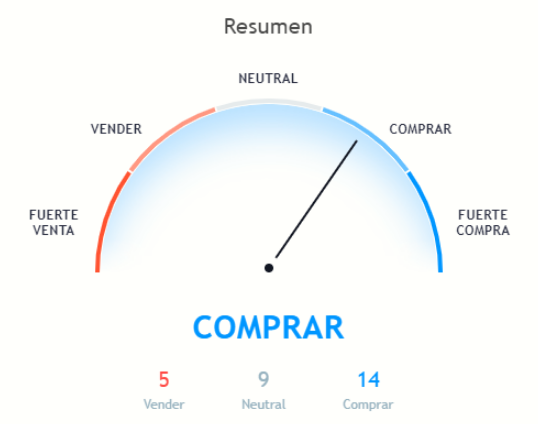

In [1]:
from IPython.display import Image, display

# Abrimos la imagen
imagenes = Image('./portada.png')

display(imagenes)

## Obtención de datos de BTC

In [2]:
# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np
import datetime

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
plt.style.use('ggplot')

### Some Scikit-learn utils
from sklearn.model_selection import train_test_split

### Metrics
from sklearn import metrics
from sklearn.metrics import accuracy_score, roc_curve, auc

### Models
from xgboost import XGBRegressor, plot_importance

# Colores Bitcoin
# ==============================================================================
palette_btc = {'naranja': '#f7931a',
               'blanco' : '#ffffff',
               'gris'   : '#4d4d4d',
               'azul'   : '#0d579b',
               'verde'  : '#329239'
              }

# Modelado y Forecasting
# ==============================================================================
from lightgbm import LGBMRegressor

from sklearn.metrics import mean_absolute_error

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import backtesting_forecaster

# Análisis de Sentimiento de twt
from textblob import TextBlob
import time
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download("vader_lexicon")
from statsmodels.graphics.tsaplots import plot_acf

C:\ProgramData\Anaconda3\envs\IA\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Carlow\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [3]:
# Descarga de datos del precio de BTC
from cryptocmd import CmcScraper
scraper = CmcScraper('BTC', '28-04-2013', '23-11-2019')
# Estas se fechas se deben a que son el rango de tiempo del cual tenemos los tweets

In [4]:
# Transformar datos recogidos en un dataframe
datos_precio_BTC = scraper.get_dataframe()
datos_precio_BTC.sort_values(by='Date', ascending=True, inplace=True)
datos_precio_BTC

Date         Open         High          Low        Close  \
2400 2013-04-28   135.300003   135.979996   132.100006   134.210007   
2399 2013-04-29   134.444000   147.488007   134.000000   144.539993   
2398 2013-04-30   144.000000   146.929993   134.050003   139.000000   
2397 2013-05-01   139.000000   139.889999   107.720001   116.989998   
2396 2013-05-02   116.379997   125.599998    92.281898   105.209999   
...         ...          ...          ...          ...          ...   
4    2019-11-19  8305.134291  8408.516128  8099.963369  8206.145918   
3    2019-11-20  8203.613180  8237.239874  8010.511901  8027.268243   
2    2019-11-21  8023.644687  8110.098131  7597.381608  7642.749945   
1    2019-11-22  7643.569425  7697.382714  6936.706599  7296.577568   
0    2019-11-23  7296.164425  7442.258933  7151.417814  7397.796815   

            Volume    Market Cap  
2400  0.000000e+00  1.488567e+09  
2399  0.000000e+00  1.603769e+09  
2398  0.000000e+00  1.542813e+09  
2397  0.000000e+00  1.298955e+09  
2396  0.000000e+00  1.168517e+09  
...            ...           ...  
4     2.108361e+10  1.481784e+11  
3     2.076430e+10  1.449627e+11  
2     2.251424e+10  1.380319e+11  
1     3.424232e+10  1.317918e+11  
0     2.100892e+10  1.336362e+11  

[2401 rows x 7 columns]

In [5]:
# Preparación de los precios
# ==============================================================================
datos_precio_BTC['date'] = pd.to_datetime(datos_precio_BTC['Date'], format='%Y-%m-%d %H:%M:%S')
datos_precio_BTC = datos_precio_BTC.loc[:, ['date', 'Open', 'Close', 'High', 'Low']]
datos_precio_BTC = datos_precio_BTC.rename({'Open': 'open', 'Close': 'close', 'High': 'high', 'Low': 'low'},axis=1) #RENOMBRAMOS LOS DATOS A MINUSCULAS
                    
datos_precio_BTC = datos_precio_BTC.set_index('date')
datos_precio_BTC = datos_precio_BTC.asfreq('D')
datos_precio_BTC = datos_precio_BTC.sort_index()

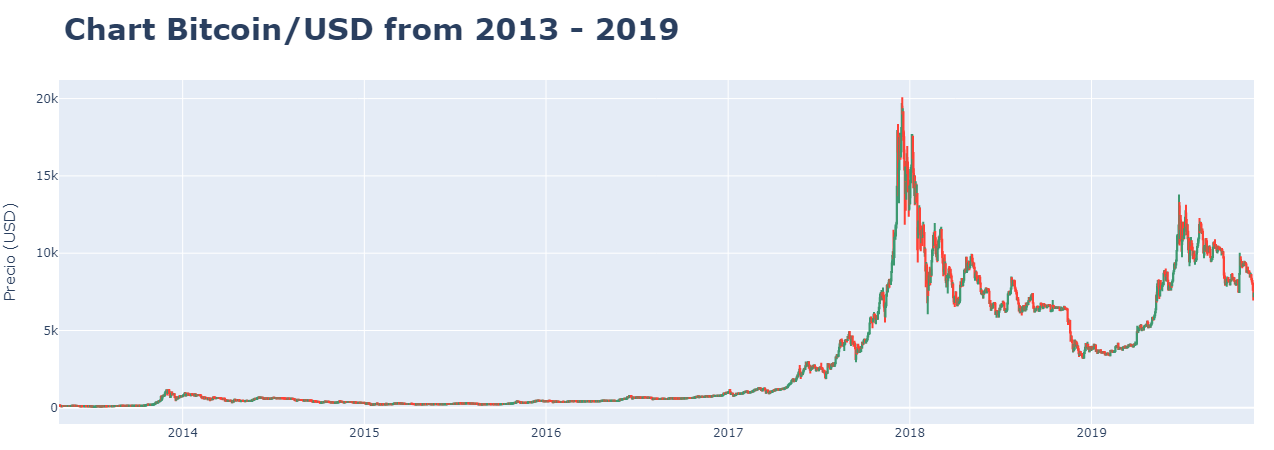

In [6]:
# Gráfico de velas japonesas interactivo con Plotly
# ==============================================================================
candlestick = go.Candlestick(
                    x     = datos_precio_BTC.index,
                    open  = datos_precio_BTC.open,
                    close = datos_precio_BTC.close,
                    low   = datos_precio_BTC.low,
                    high  = datos_precio_BTC.high,
                    )

fig = go.Figure(data=[candlestick])

fig.update_layout(
    width       = 900,
    height      = 450,
    title       = dict(text='<b>Chart Bitcoin/USD from 2013 - 2019</b>', font=dict(size=30)),
    yaxis_title = dict(text='Precio (USD)', font=dict(size=15)),
    margin      = dict(l=10, r=20, t=80, b=20),
    xaxis_rangeslider_visible = False,
)

fig.show()

## ANALISIS - Modelos
## (Random Walk)

In [7]:
# Selección fechas  para utilizar como train
# ==============================================================================
inicio_train = '2015-01-01 00:00:00'
fin_train = '2018-10-30 23:59:59'

In [8]:
# Simulación Random Walk
# ==============================================================================
df_rw = datos_precio_BTC[['close']].copy()
df_rw['pred_close'] = df_rw['close'].shift(1)

# Calculamos el error de este TEST
# ==============================================================================
y_true = df_rw.loc[fin_train:, 'close']
y_pred = df_rw.loc[fin_train:, 'pred_close']
metrica = mean_absolute_error(y_true, y_pred)

print(f'Error de test: {metrica}')
display(df_rw.loc[fin_train:,].head(4))

Error de test: 186.83289766385602


close  pred_close
date                           
2018-10-31  6317.61     6334.27
2018-11-01  6377.78     6317.61
2018-11-02  6388.44     6377.78
2018-11-03  6361.26     6388.44

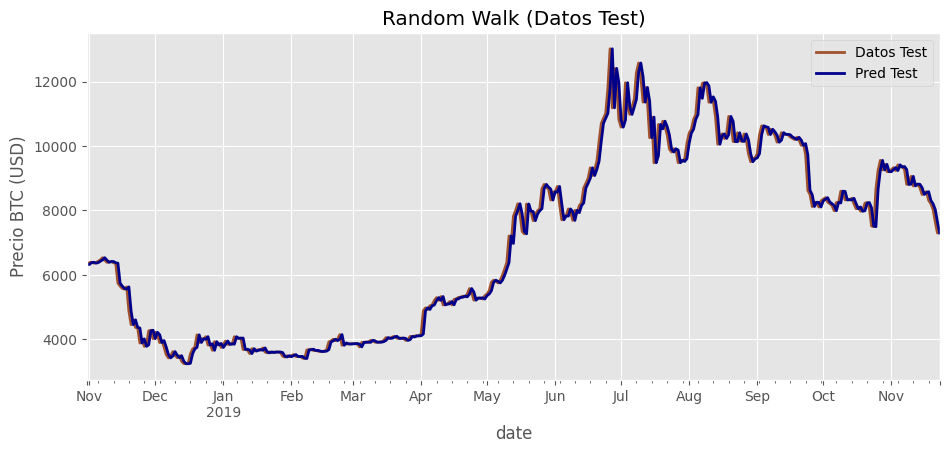

In [9]:
# Gráfico Random Walk
# ==============================================================================
fig, ax = plt.subplots(figsize=(11, 4.5))
df_rw.loc[fin_train:, 'close'].plot(ax=ax, linewidth=2, label='Datos Test',
                                    c='sienna')
df_rw.loc[fin_train:, 'pred_close'].plot(ax=ax, linewidth=2, label='Pred Test',
                                    c='darkblue')
ax.set_title('Random Walk (Datos Test)')
ax.set_ylabel('Precio BTC (USD)')
ax.legend();

In [10]:
# DataFrame errores TEST modelos
# ==============================================================================
df_errores = pd.DataFrame({'modelo': 'Random Walk Base', 'lags': 1, 
                           'error_test': metrica, 'variables_exog': False},
                          index=[0])
df_errores

modelo  lags  error_test  variables_exog
0  Random Walk Base     1  186.832898           False

## ANALISIS
## Forecaster Autorregresivo

Los lags son una medida de la distancia entre dos puntos en una serie de tiempo. En el contexto de modelos de series temporales, los lags se utilizan para incluir información pasada en la predicción de valores futuros.

Por ejemplo, si tienes una serie de tiempo con el número de ventas mensuales de un producto y quieres hacer una predicción del número de ventas para el mes siguiente, podrías incluir los datos de ventas de los últimos 12 meses como lags para mejorar la precisión de la predicción.

Los lags se suelen representar como una lista de números enteros, donde cada número representa la distancia en meses entre el punto actual y el punto anterior que se está considerando. Por ejemplo, si tienes una lista de lags [1, 2, 3, 6, 12], significa que estás considerando la información de los últimos 1, 2, 3, 6 y 12 meses para hacer la predicción.

In [11]:
# Backtest forecasters con diferentes lags
# ==============================================================================
lags = [1, 7, 30]
metricas = []
predicciones_list = []

for lag in lags:
    
    # Crear forecaster
    forecaster = ForecasterAutoreg(
                    regressor = LGBMRegressor(random_state=123),
                    lags      = lag
                    )
    
    # Backtest test df_rw
    metrica, predicciones = backtesting_forecaster(
                                 forecaster = forecaster,
                                 y          = df_rw.loc[inicio_train:, 'close'],
                                 initial_train_size = len(df_rw.loc[inicio_train:fin_train, 'close']),
                                 fixed_train_size   = True,
                                 steps      = 1,
                                 refit      = True,
                                 metric     = 'mean_absolute_error',
                                 verbose    = False
                                 )
    
    metricas.append(metrica)
    predicciones_list.append(predicciones)

C:\ProgramData\Anaconda3\envs\IA\lib\site-packages\skforecast\model_selection\model_selection.py:369: RuntimeWarning:

The forecaster will be fit 389 times. This can take substantial amounts of time. If not feasible, try with `refit = False`. 


C:\ProgramData\Anaconda3\envs\IA\lib\site-packages\skforecast\model_selection\model_selection.py:369: RuntimeWarning:

The forecaster will be fit 389 times. This can take substantial amounts of time. If not feasible, try with `refit = False`. 


C:\ProgramData\Anaconda3\envs\IA\lib\site-packages\skforecast\model_selection\model_selection.py:369: RuntimeWarning:

The forecaster will be fit 389 times. This can take substantial amounts of time. If not feasible, try with `refit = False`. 




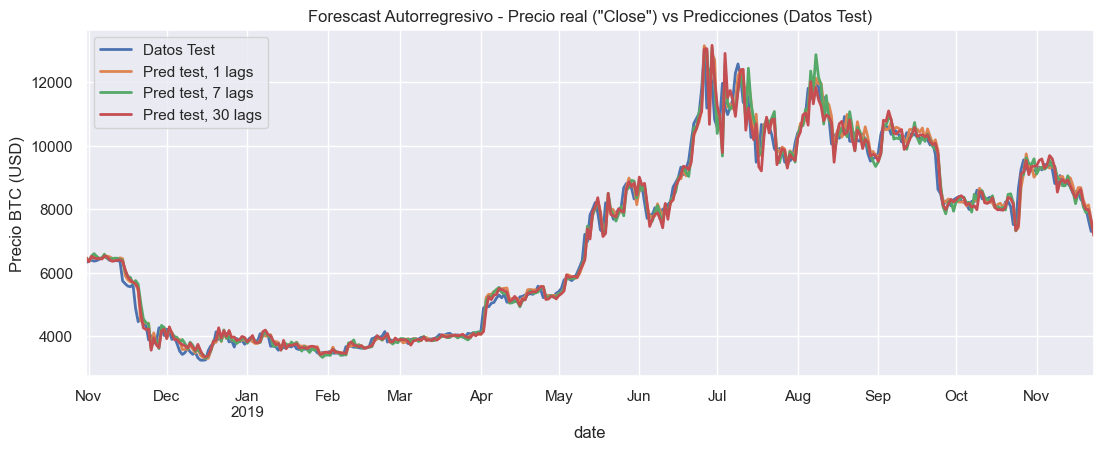

In [71]:
# Gráfico General Unido
# ==============================================================================
fig, ax = plt.subplots(figsize=(13, 4.5))
df_rw.loc[fin_train:, 'close'].plot(ax=ax, linewidth=2, label='Datos Test')

# Plot predicciones test para diferentes lags
for predicciones, lag in zip(predicciones_list, lags):
    predicciones = predicciones.rename(columns={'pred': f'Pred test, {lag} lags'})
    predicciones.plot(ax=ax, linewidth=2)

ax.set_title('Forescast Autorregresivo - Precio real ("Close") vs Predicciones (Datos Test)')
ax.set_ylabel('Precio BTC (USD)')
ax.legend();

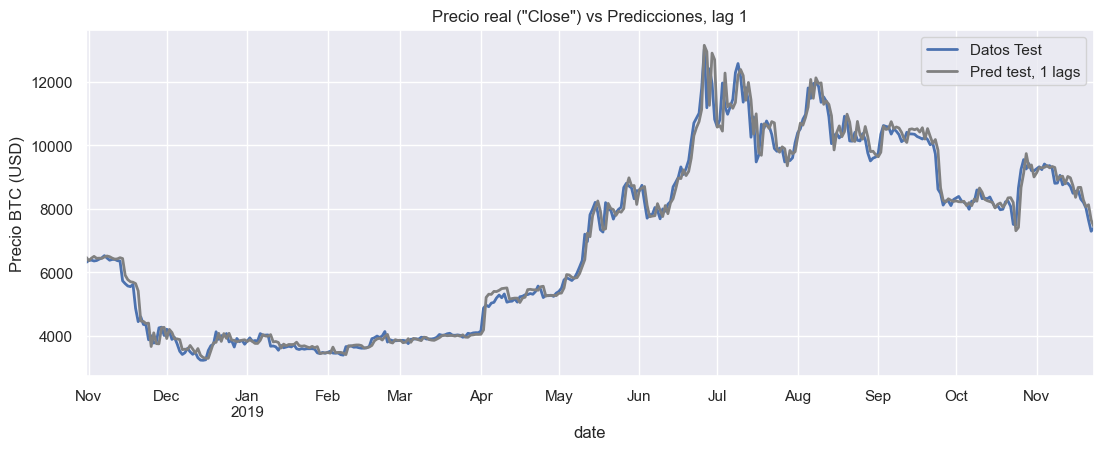

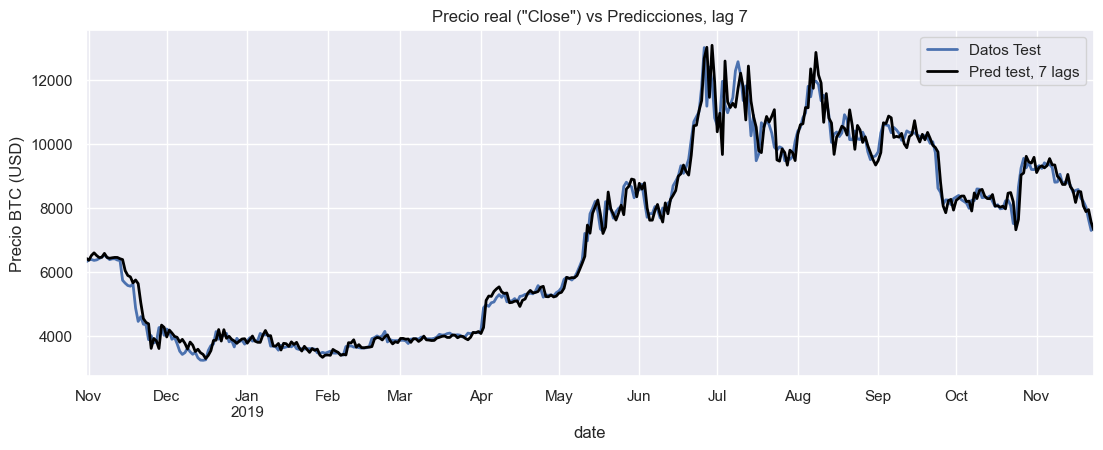

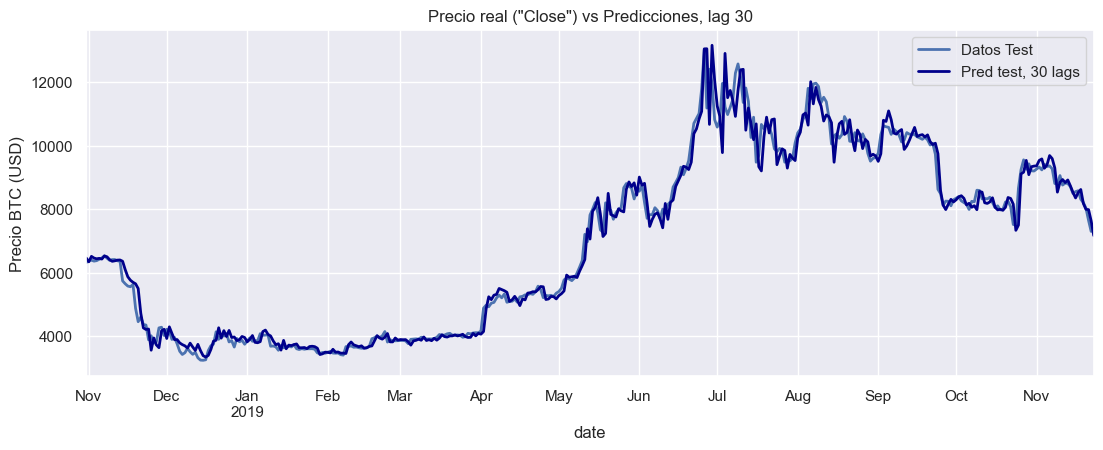

In [70]:
colors = ['grey', 'black', 'darkblue']
for i, predicciones in enumerate(predicciones_list):
    fig, ax = plt.subplots(figsize=(13, 4.5))
    df_rw.loc[fin_train:, 'close'].plot(ax=ax, linewidth=2, label='Datos Test')
    predicciones = predicciones.rename(columns={'pred': f'Pred test, {lags[i]} lags'})
    predicciones.plot(ax=ax, linewidth=2, color=colors[i])

    ax.set_title(f'Precio real ("Close") vs Predicciones, lag {lags[i]}')
    ax.set_ylabel('Precio BTC (USD)')
    ax.legend()

In [14]:
# DataFrame errores de test modelos
# ==============================================================================
modelo = 'LGBMRegressor'

df_errores = pd.concat([
                df_errores,
                pd.DataFrame({'modelo': modelo, 'lags': lags, 
                              'error_test': metricas, 'variables_exog': False})
                ]).reset_index(drop=True)

df_errores.sort_values(by='error_test')

modelo  lags  error_test  variables_exog
0  Random Walk Base     1  186.832898           False
1     LGBMRegressor     1  215.440988           False
2     LGBMRegressor     7  231.296279           False
3     LGBMRegressor    30  238.954345           False

Los errores de test (los cuales reflejan cómo de bien generaliza cada modelo) demuestran que ninguno de los modelos mejora el baseline a pesar de que se incorpore más información del pasado (número de lags).

AHORA VAMOS A COMPROBAR SI CON LOS DATOS EXTRAIDOS DE LOS TWEETS PODEMOS COMPROBAR SI EXISTE UNA MEJORA Y UNA PREDICCIÓN DE BTC

## DATOS del CSV - Tweets

##### Utilizamos Pandas para cargar los datos del archivo .csv que hemos obtenido de kaggle
https://www.kaggle.com/datasets/alaix14/bitcoin-tweets-20160101-to-20190329

dfcsv = pd.read_csv('./data/tweetsKaggle.csv',sep=';', usecols=['timestamp','user','text'])
dfcsv.head()

### TRATAMIENTO DE DATOS - CSV Tweets ("BTC")

In [73]:
dfcsv.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18809800 entries, 0 to 20165012
Data columns (total 3 columns):
 #   Column        Dtype         
---  ------        -----         
 0   text          object        
 1   Fecha         datetime64[ns]
 2   sentimientos  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 574.0+ MB


In [16]:
# Separamos la hora de la fecha, ya que la hora no nos interesa
dfcsv[['Date','Time']] = dfcsv.timestamp.str.split(expand=True)
dfcsv.head()

user               timestamp  \
0   KamdemAbdiel  2019-05-27 11:49:14+00   
1      bitcointe  2019-05-27 11:49:18+00   
2      3eyedbran  2019-05-27 11:49:06+00   
3  DetroitCrypto  2019-05-27 11:49:22+00   
4   mmursaleen72  2019-05-27 11:49:23+00   

                                                text        Date         Time  
0  È appena uscito un nuovo video! LES CRYPTOMONN...  2019-05-27  11:49:14+00  
1  Cardano: Digitize Currencies; EOS https://t.co...  2019-05-27  11:49:18+00  
2  Another Test tweet that wasn't caught in the s...  2019-05-27  11:49:06+00  
3  Current Crypto Prices! \n\nBTC: $8721.99 USD\n...  2019-05-27  11:49:22+00  
4  Spiv (Nosar Baz): BITCOIN Is An Asset &amp; NO...  2019-05-27  11:49:23+00

In [17]:
#Unicamente nos quedamos con la fecha y el texto del tweet
dfcsv=dfcsv[['Date','text']]
dfcsv.head()

Date                                               text
0  2019-05-27  È appena uscito un nuovo video! LES CRYPTOMONN...
1  2019-05-27  Cardano: Digitize Currencies; EOS https://t.co...
2  2019-05-27  Another Test tweet that wasn't caught in the s...
3  2019-05-27  Current Crypto Prices! \n\nBTC: $8721.99 USD\n...
4  2019-05-27  Spiv (Nosar Baz): BITCOIN Is An Asset &amp; NO...

In [18]:
#Comprobamos valores nulos y borramos aquellas filas que contengan uno
print(dfcsv.isnull().sum())
dfcsv = dfcsv.dropna()

Date    1354492
text    1355213
dtype: int64


In [19]:
# Convertimos la columna "date" a DatetimeIndex
date_index = pd.to_datetime(dfcsv['Date'])
dfcsv = dfcsv.drop('Date', axis=1) # eliminamos la columna date ya que ya no nos interesa
dfcsv['Fecha'] = date_index # Guardamos el DatetimeIndex en la columna "Fecha"
dfcsv.drop_duplicates() # Comprobamos por si acaso que haya algun valor duplicado

text      Fecha
0         È appena uscito un nuovo video! LES CRYPTOMONN... 2019-05-27
1         Cardano: Digitize Currencies; EOS https://t.co... 2019-05-27
2         Another Test tweet that wasn't caught in the s... 2019-05-27
3         Current Crypto Prices! \n\nBTC: $8721.99 USD\n... 2019-05-27
4         Spiv (Nosar Baz): BITCOIN Is An Asset &amp; NO... 2019-05-27
...                                                     ...        ...
20165008  Happy #FibonacciDay \n\nA while back I created... 2019-11-23
20165009  Bitcoin Suisse Certificates :) https://t.co/nd... 2019-11-23
20165010  Register now for the early access of the Codug... 2019-11-23
20165011  @btc \n@btc \nDo you know that BTC Baskets isn... 2019-11-23
20165012  $BTC - an update on the longer term view for B... 2019-11-23

[16154198 rows x 2 columns]

## ANÁLISIS DE SENTIMIENTOS DE LOS TEXTOS DE LOS TWEETS

In [20]:
analyzer = SentimentIntensityAnalyzer()
sentimientos = []
for texto in dfcsv['text']:
    sentiment = analyzer.polarity_scores(texto)
    analisis = sentiment['compound']
    sentimientos.append(analisis)
    
dfcsv['sentimientos'] = sentimientos

In [21]:
dfcsv

text      Fecha  \
0         È appena uscito un nuovo video! LES CRYPTOMONN... 2019-05-27   
1         Cardano: Digitize Currencies; EOS https://t.co... 2019-05-27   
2         Another Test tweet that wasn't caught in the s... 2019-05-27   
3         Current Crypto Prices! \n\nBTC: $8721.99 USD\n... 2019-05-27   
4         Spiv (Nosar Baz): BITCOIN Is An Asset &amp; NO... 2019-05-27   
...                                                     ...        ...   
20165008  Happy #FibonacciDay \n\nA while back I created... 2019-11-23   
20165009  Bitcoin Suisse Certificates :) https://t.co/nd... 2019-11-23   
20165010  Register now for the early access of the Codug... 2019-11-23   
20165011  @btc \n@btc \nDo you know that BTC Baskets isn... 2019-11-23   
20165012  $BTC - an update on the longer term view for B... 2019-11-23   

          sentimientos  
0               0.0000  
1              -0.1027  
2               0.0000  
3               0.0000  
4               0.3612  
...                ...  
20165008        0.9273  
20165009        0.4588  
20165010        0.0000  
20165011        0.8549  
20165012        0.4902  

[18809800 rows x 3 columns]

In [22]:
# Sumamos todos los sentimos de cada uno de los días para tener un sumatorio general diario
dfdiario = dfcsv.groupby(by="Fecha").sum()

C:\Users\Carlow\AppData\Local\Temp\ipykernel_27616\766680519.py:2: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



In [23]:
dfdiario

sentimientos
Fecha                   
2007-04-19        0.8516
2009-01-11        0.0000
2009-01-21        0.0000
2009-01-27        0.0000
2009-01-29        0.0000
...                  ...
2019-11-19     7533.9115
2019-11-20     8233.7962
2019-11-21     7929.8912
2019-11-22     6979.5915
2019-11-23     4115.8980

[3005 rows x 1 columns]

In [24]:
# Observamos que nos faltaban precios en algunas de algunos de los tweets por lo que debemos introducirlas a mano
df_temp = dfdiario.loc['28-04-2013':'2019-11-23', 'sentimientos']

C:\Users\Carlow\AppData\Local\Temp\ipykernel_27616\1402322768.py:2: UserWarning:

Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.



In [25]:
#Recibimos una serie
df_temp

Fecha
2013-04-28     202.3799
2013-04-29     259.7060
2013-04-30     293.0840
2013-05-01     465.5918
2013-05-02     329.7839
                ...    
2019-11-19    7533.9115
2019-11-20    8233.7962
2019-11-21    7929.8912
2019-11-22    6979.5915
2019-11-23    4115.8980
Name: sentimientos, Length: 2401, dtype: float64

In [26]:
#Calculamos el precio promedio para asignarlos a los campos vacíos
promedio = df_temp.mean()

In [27]:
#Localizamos los campos vacios
fechasfaltantes = pd.date_range(start = '2008-01-01 ', end = '2019-05-27' ).difference(dfdiario.index)

In [28]:
#Asignamos a los campos vacíos los promedios para rellenar los huecos
fechas_faltantes = pd.DataFrame(fechasfaltantes, columns = ["Fecha"])
fechas_faltantes["sentimientos"] = promedio

In [29]:
fechas_faltantes

Fecha  sentimientos
0    2008-01-01    846.955887
1    2008-01-02    846.955887
2    2008-01-03    846.955887
3    2008-01-04    846.955887
4    2008-01-05    846.955887
...         ...           ...
1336 2011-12-25    846.955887
1337 2011-12-26    846.955887
1338 2011-12-27    846.955887
1339 2011-12-28    846.955887
1340 2011-12-29    846.955887

[1341 rows x 2 columns]

In [30]:
fechas_faltantes.reset_index(inplace=True)
fechas_faltantes.drop(columns=["index"],inplace=True)

In [31]:
fechas_faltantes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1341 entries, 0 to 1340
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Fecha         1341 non-null   datetime64[ns]
 1   sentimientos  1341 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 21.1 KB


In [32]:
# lo pasamos a dataframe
dfadjunto = df_temp.to_frame()

In [33]:
dfadjunto

sentimientos
Fecha                   
2013-04-28      202.3799
2013-04-29      259.7060
2013-04-30      293.0840
2013-05-01      465.5918
2013-05-02      329.7839
...                  ...
2019-11-19     7533.9115
2019-11-20     8233.7962
2019-11-21     7929.8912
2019-11-22     6979.5915
2019-11-23     4115.8980

[2401 rows x 1 columns]

In [34]:
dfadjunto.reset_index(inplace=True)

In [35]:
dfadjunto

Fecha  sentimientos
0    2013-04-28      202.3799
1    2013-04-29      259.7060
2    2013-04-30      293.0840
3    2013-05-01      465.5918
4    2013-05-02      329.7839
...         ...           ...
2396 2019-11-19     7533.9115
2397 2019-11-20     8233.7962
2398 2019-11-21     7929.8912
2399 2019-11-22     6979.5915
2400 2019-11-23     4115.8980

[2401 rows x 2 columns]

In [36]:
# Juntamos los dos dataframes en uno mismo
dffinal = fechas_faltantes.merge(dfadjunto, on='Fecha', how='outer')

# Ordenamos el dataframe por la columna fecha
dffinal = dffinal.sort_values('Fecha')

In [37]:
dffinal

Fecha  sentimientos_x  sentimientos_y
0    2008-01-01      846.955887             NaN
1    2008-01-02      846.955887             NaN
2    2008-01-03      846.955887             NaN
3    2008-01-04      846.955887             NaN
4    2008-01-05      846.955887             NaN
...         ...             ...             ...
3737 2019-11-19             NaN       7533.9115
3738 2019-11-20             NaN       8233.7962
3739 2019-11-21             NaN       7929.8912
3740 2019-11-22             NaN       6979.5915
3741 2019-11-23             NaN       4115.8980

[3742 rows x 3 columns]

In [38]:
#Rellenamos los valores NaN con valores 0 para poder sumar las dos columna
dffinal = dffinal.fillna(value=0)
dffinal['sentimiento'] = dffinal['sentimientos_x'] + dffinal['sentimientos_y']

In [39]:
dffinal

Fecha  sentimientos_x  sentimientos_y  sentimiento
0    2008-01-01      846.955887          0.0000   846.955887
1    2008-01-02      846.955887          0.0000   846.955887
2    2008-01-03      846.955887          0.0000   846.955887
3    2008-01-04      846.955887          0.0000   846.955887
4    2008-01-05      846.955887          0.0000   846.955887
...         ...             ...             ...          ...
3737 2019-11-19        0.000000       7533.9115  7533.911500
3738 2019-11-20        0.000000       8233.7962  8233.796200
3739 2019-11-21        0.000000       7929.8912  7929.891200
3740 2019-11-22        0.000000       6979.5915  6979.591500
3741 2019-11-23        0.000000       4115.8980  4115.898000

[3742 rows x 4 columns]

In [40]:
dffinal = dffinal.drop(columns=['sentimientos_x','sentimientos_y'])
dffinal = dffinal.sort_values(by='Fecha')
dffinal.reset_index(inplace=True)
dffinal = dffinal.drop(columns=['index'])

In [41]:
dffinal

Fecha  sentimiento
0    2008-01-01   846.955887
1    2008-01-02   846.955887
2    2008-01-03   846.955887
3    2008-01-04   846.955887
4    2008-01-05   846.955887
...         ...          ...
3737 2019-11-19  7533.911500
3738 2019-11-20  8233.796200
3739 2019-11-21  7929.891200
3740 2019-11-22  6979.591500
3741 2019-11-23  4115.898000

[3742 rows x 2 columns]

In [42]:
# Cambiamos el nombre para juntarlo con el de BTC
dffinal = dffinal.rename(columns={'Fecha': 'Date'})
dffinal = dffinal[dffinal['Date'] >= '2013-04-28']

In [43]:
dffinal

Date  sentimiento
1341 2013-04-28     202.3799
1342 2013-04-29     259.7060
1343 2013-04-30     293.0840
1344 2013-05-01     465.5918
1345 2013-05-02     329.7839
...         ...          ...
3737 2019-11-19    7533.9115
3738 2019-11-20    8233.7962
3739 2019-11-21    7929.8912
3740 2019-11-22    6979.5915
3741 2019-11-23    4115.8980

[2401 rows x 2 columns]

## Juntamos los datos del analisis con el dataframe de BTC que hemos conseguido al principio

In [44]:
datos = scraper.get_dataframe()
datos.sort_values(by='Date', ascending=True, inplace=True)
pd.set_option('display.max_columns', None)
pd.reset_option('display.max_columns')

In [45]:
datos

Date         Open         High          Low        Close  \
2400 2013-04-28   135.300003   135.979996   132.100006   134.210007   
2399 2013-04-29   134.444000   147.488007   134.000000   144.539993   
2398 2013-04-30   144.000000   146.929993   134.050003   139.000000   
2397 2013-05-01   139.000000   139.889999   107.720001   116.989998   
2396 2013-05-02   116.379997   125.599998    92.281898   105.209999   
...         ...          ...          ...          ...          ...   
4    2019-11-19  8305.134291  8408.516128  8099.963369  8206.145918   
3    2019-11-20  8203.613180  8237.239874  8010.511901  8027.268243   
2    2019-11-21  8023.644687  8110.098131  7597.381608  7642.749945   
1    2019-11-22  7643.569425  7697.382714  6936.706599  7296.577568   
0    2019-11-23  7296.164425  7442.258933  7151.417814  7397.796815   

            Volume    Market Cap  
2400  0.000000e+00  1.488567e+09  
2399  0.000000e+00  1.603769e+09  
2398  0.000000e+00  1.542813e+09  
2397  0.000000e+00  1.298955e+09  
2396  0.000000e+00  1.168517e+09  
...            ...           ...  
4     2.108361e+10  1.481784e+11  
3     2.076430e+10  1.449627e+11  
2     2.251424e+10  1.380319e+11  
1     3.424232e+10  1.317918e+11  
0     2.100892e+10  1.336362e+11  

[2401 rows x 7 columns]

In [46]:
# Juntamos los dos dataframes
dfdatossentimientos = dffinal.merge(datos, on='Date', how='outer')

In [47]:
dfdatossentimientos

Date  sentimiento         Open         High          Low  \
0    2013-04-28     202.3799   135.300003   135.979996   132.100006   
1    2013-04-29     259.7060   134.444000   147.488007   134.000000   
2    2013-04-30     293.0840   144.000000   146.929993   134.050003   
3    2013-05-01     465.5918   139.000000   139.889999   107.720001   
4    2013-05-02     329.7839   116.379997   125.599998    92.281898   
...         ...          ...          ...          ...          ...   
2396 2019-11-19    7533.9115  8305.134291  8408.516128  8099.963369   
2397 2019-11-20    8233.7962  8203.613180  8237.239874  8010.511901   
2398 2019-11-21    7929.8912  8023.644687  8110.098131  7597.381608   
2399 2019-11-22    6979.5915  7643.569425  7697.382714  6936.706599   
2400 2019-11-23    4115.8980  7296.164425  7442.258933  7151.417814   

            Close        Volume    Market Cap  
0      134.210007  0.000000e+00  1.488567e+09  
1      144.539993  0.000000e+00  1.603769e+09  
2      139.000000  0.000000e+00  1.542813e+09  
3      116.989998  0.000000e+00  1.298955e+09  
4      105.209999  0.000000e+00  1.168517e+09  
...           ...           ...           ...  
2396  8206.145918  2.108361e+10  1.481784e+11  
2397  8027.268243  2.076430e+10  1.449627e+11  
2398  7642.749945  2.251424e+10  1.380319e+11  
2399  7296.577568  3.424232e+10  1.317918e+11  
2400  7397.796815  2.100892e+10  1.336362e+11  

[2401 rows x 8 columns]

In [48]:
sentimiento = dfdatossentimientos['sentimiento']

In [49]:
# Creamos un nuevo dataframe adjunto para poder trabajar y realizar las operacciones
df_rw2 = pd.DataFrame()

In [50]:
# Recogemos los precios de Close, el sentimient y la fecha "Date"
df_rw2["Close"] = dfdatossentimientos[['Close']].copy()
df_rw2['sentimiento'] = dfdatossentimientos[['sentimiento']].copy()
df_rw2["Date"] = dfdatossentimientos[['Date']].copy()

In [51]:
df_rw2=df_rw2.fillna(313.128993)

In [52]:
df_rw2

Close  sentimiento       Date
0      134.210007     202.3799 2013-04-28
1      144.539993     259.7060 2013-04-29
2      139.000000     293.0840 2013-04-30
3      116.989998     465.5918 2013-05-01
4      105.209999     329.7839 2013-05-02
...           ...          ...        ...
2396  8206.145918    7533.9115 2019-11-19
2397  8027.268243    8233.7962 2019-11-20
2398  7642.749945    7929.8912 2019-11-21
2399  7296.577568    6979.5915 2019-11-22
2400  7397.796815    4115.8980 2019-11-23

[2401 rows x 3 columns]

In [53]:
df_rw2.isna().sum()

Close          0
sentimiento    0
Date           0
dtype: int64

## GRÁFICO PRECIO DE BTC frente los sentimientos de twt con el término "BTC" durante 2013-04-28 -- 2019-11-23

<AxesSubplot: title={'center': 'Comparación de Análisis con Precio de BTC'}, xlabel='Date', ylabel='Suma de valores'>

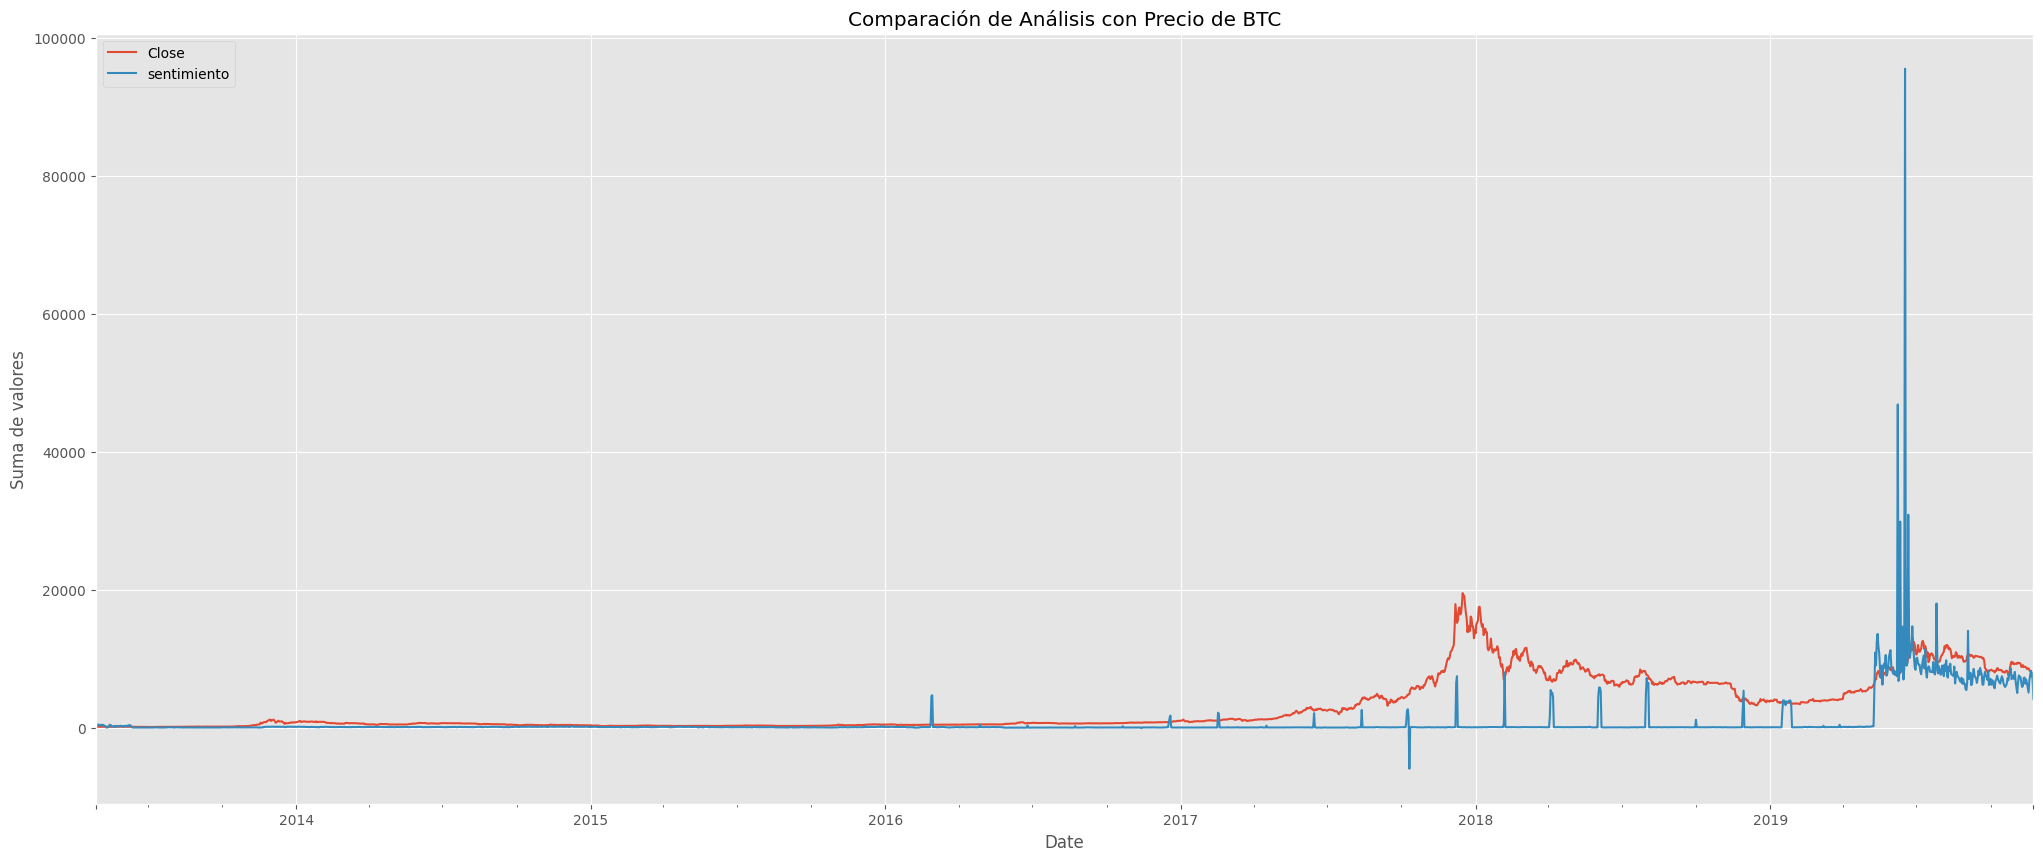

In [55]:
dfgrafico3 = df_rw2.clip()
dfgrafico3.plot(x="Date", kind='line', title='Comparación de Análisis con Precio de BTC', ylabel='Suma de valores', figsize=(25,10))

In [54]:
#Podriamos cargar este df en un csv para no tener que volver a ejecutar lo anterior
"""df_rw2.to_csv("./data/Close_Sentimiento_Date_16M_2013-04-28_2019-11-23.csv", index=False)"""

'df_rw2.to_csv("./data/Close_Sentimiento_Date_16M_2013-04-28_2019-11-23.csv", index=False)'

 + Podemos observar que en las fechas desde 2013 hasta 2017 no hubo ninguna relevancia de BTC en twitter.
 + A partir de 2017 en adelante hubo algunos repuntes en el sentimiento, pero la subida masiva del precio no ha sido en proproción a los repuntes de sentimiento. Por lo que podriamos decir que en estas fechas no tienen correlación.
 + En cambio en el año de de 2019 podemos observar que hubo sentimiento muy positivo y podemos ver que el precio también subió por lo que podriamos decir que en este caso si están relacionados.

<AxesSubplot: title={'center': 'Diagrama de Cajas del sentimiento de Twitter acerca de BTC'}, xlabel='Fecha', ylabel='Suma de valores de sentimiento'>

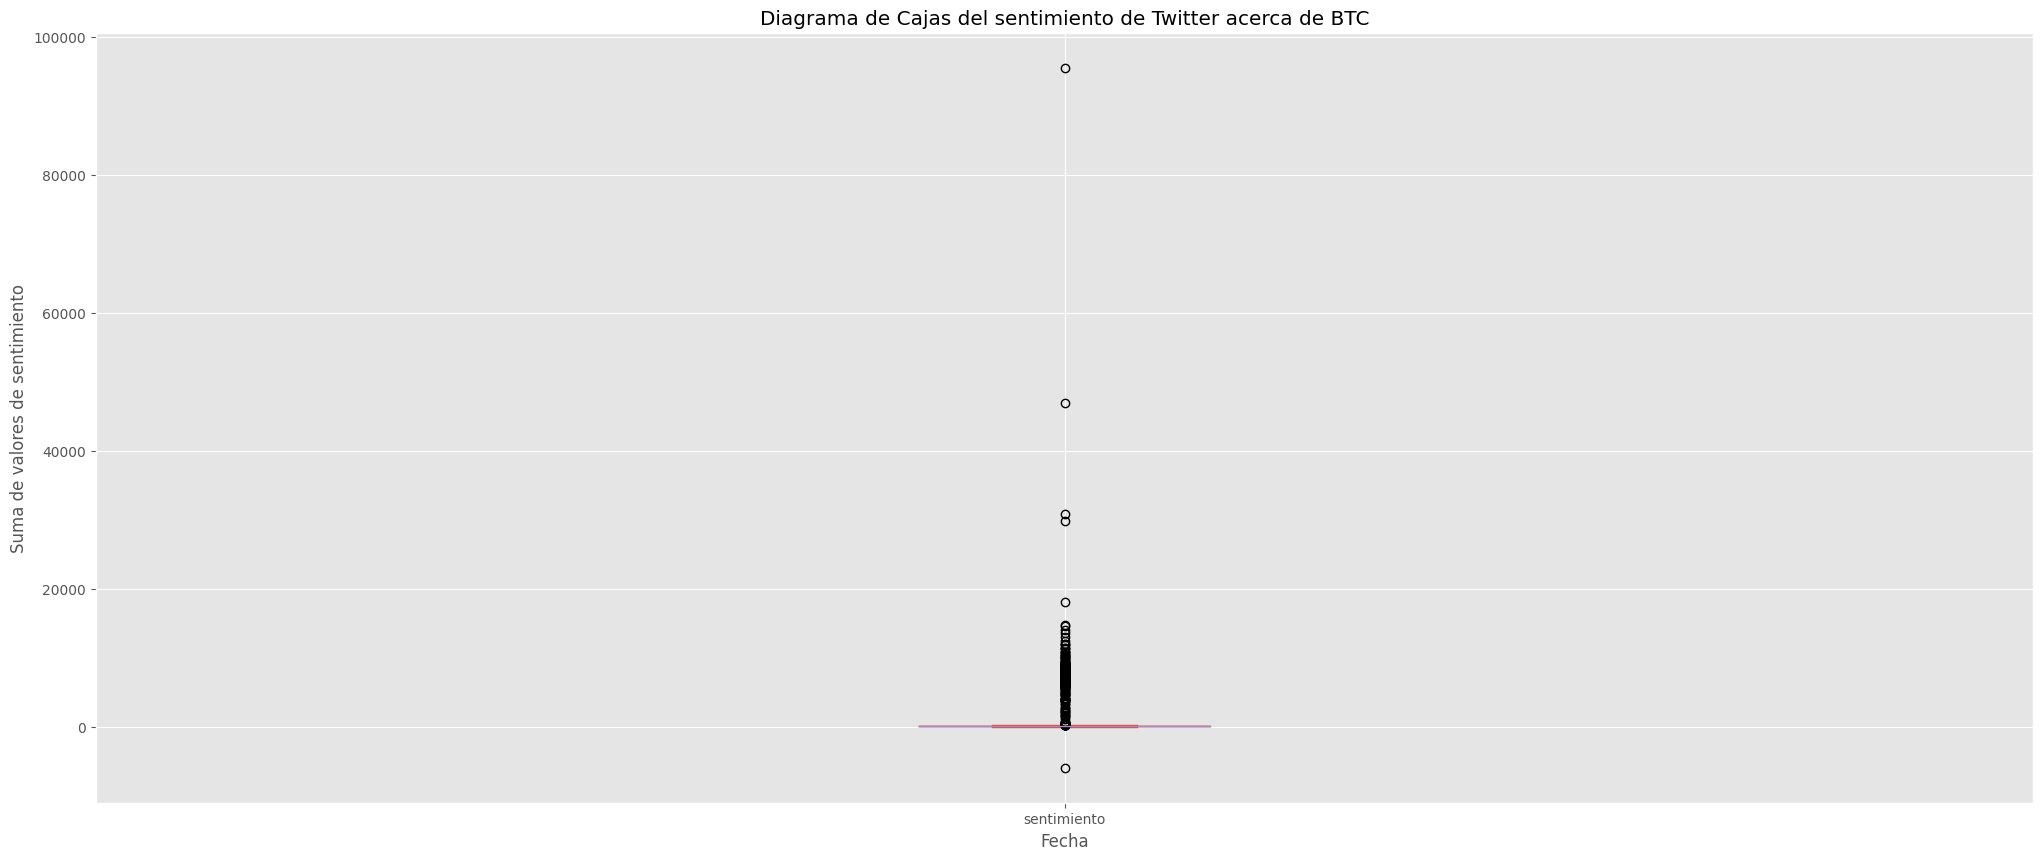

In [56]:
dfgrafico3.plot(x="Date",y="sentimiento", kind='box', title='Diagrama de Cajas del sentimiento de Twitter acerca de BTC', xlabel='Fecha', ylabel='Suma de valores de sentimiento', figsize=(25,10))

 + La dispersión de los sentimientos de twittter frente a BTC es muy alta, concentrándose la gran mayria entre 0 y 20000. 
 + También se puede observar varios repuntes, algunos positivos entre los que destaca uno muy positivo, cerca de los 100,000. Abajo, también podemos ver un repunte negativo

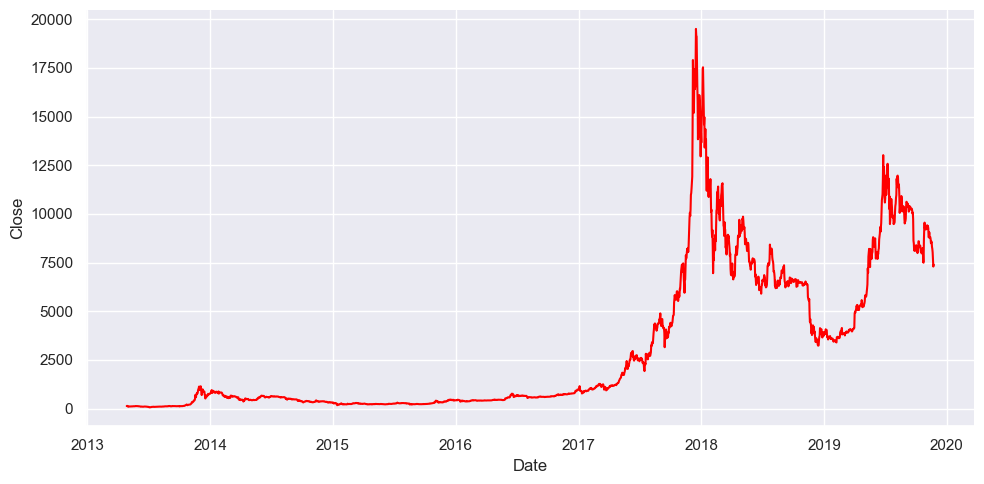

In [72]:
# Precio de BTC
sns.set()
sns.relplot(data=df_rw2, x='Date', y='Close', kind='line', height=5, aspect=2, color='red');    

 + Aquí podemos observar la gráfica del precio de BTC por separado

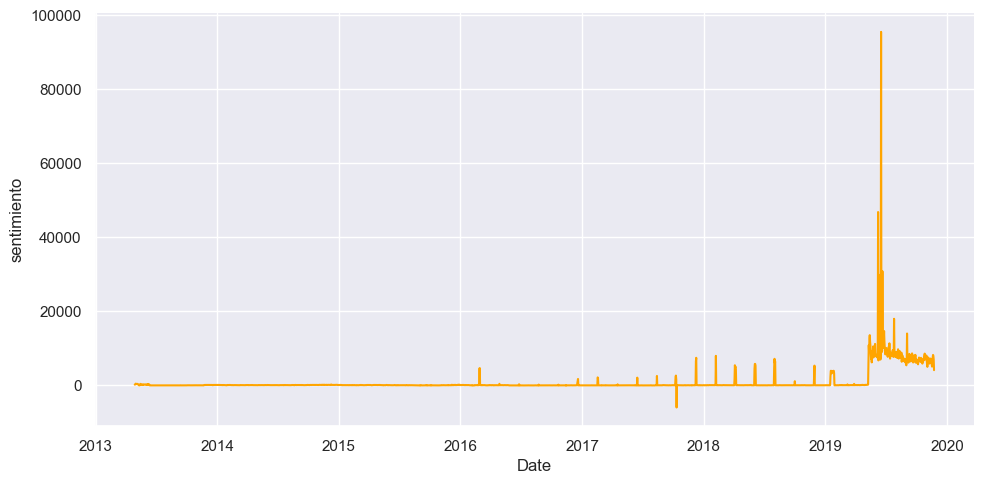

In [58]:
# Sentimiento por separado
sns.set()
sns.relplot(data=df_rw2, x='Date', y='sentimiento', kind='line', height=5, aspect=2, color='orange');  

 + Aquí podemos observar la gráfica del sentimiento de Twitter sobre "BTC" por separado

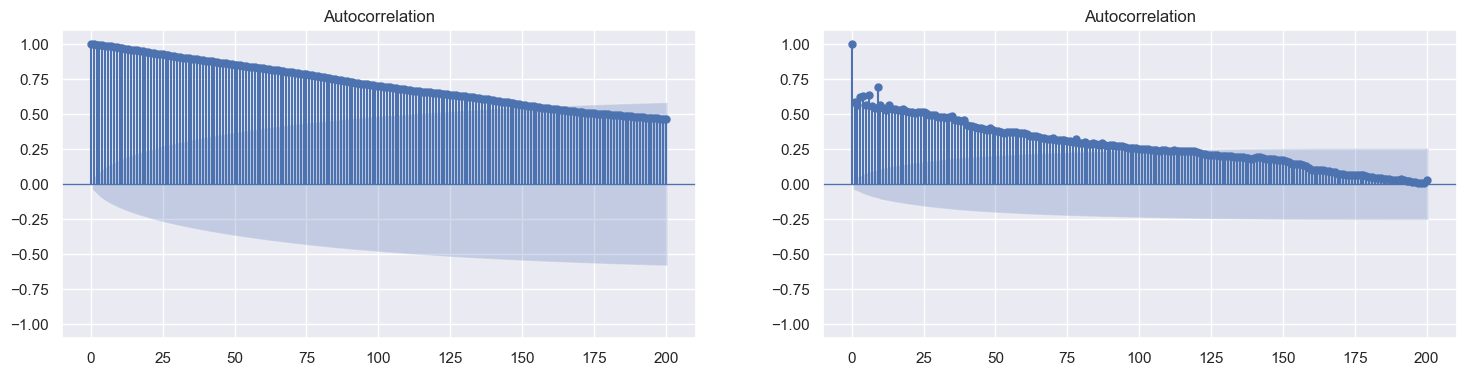

In [59]:
# Gráfico autocorrelación
# ==============================================================================
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 4))
axes = axes.flat
plot_acf(df_rw2["Close"], ax=axes[0], linewidth = 1, lags=200)
axes[0].set_ylim(-1.1, 1.1)
plot_acf(df_rw2["sentimiento"], ax=axes[1], linewidth = 1, lags=200)
axes[1].set_ylim(-1.1, 1.1)
plt.show();

 + Aquí pdemos observar la autocorrelación del precio de BTC y del sentimiento de twitter sobre BTC respectivamente.

In [60]:
#Aquí podriamos cargar el csv en un dataframe po si unicamente queremos cargar esta última parte
"""df_rw2= pd.read_csv("./data/Close_Sentimiento_Date_16M_2013-04-28_2019-11-23.csv")"""

'df_rw2= pd.read_csv("./data/Close_Sentimiento_Date_16M_2013-04-28_2019-11-23.csv")'

In [61]:
df_rw2

Close  sentimiento       Date
0      134.210007     202.3799 2013-04-28
1      144.539993     259.7060 2013-04-29
2      139.000000     293.0840 2013-04-30
3      116.989998     465.5918 2013-05-01
4      105.209999     329.7839 2013-05-02
...           ...          ...        ...
2396  8206.145918    7533.9115 2019-11-19
2397  8027.268243    8233.7962 2019-11-20
2398  7642.749945    7929.8912 2019-11-21
2399  7296.577568    6979.5915 2019-11-22
2400  7397.796815    4115.8980 2019-11-23

[2401 rows x 3 columns]

In [62]:
df_rw2["pred_close"]=df_rw2["Close"].shift(1).astype(float)
df_rw2=df_rw2.fillna(130.4)

In [63]:
# Calculamos la diferencia de precio de un día con su día anterior para ver si ha sido positivo o negativo
df_rw2["valor_precio"]=df_rw2["Close"]-df_rw2["pred_close"]
df_rw2['cambioPrecio'] = [1 if x > 0 else -1 for x in df_rw2['valor_precio']]
df_rw2['cambioSentimiento'] = [1 if x > 0 else -1 for x in df_rw2['sentimiento']]

In [64]:
df_rw2

Close  sentimiento       Date   pred_close  valor_precio  \
0      134.210007     202.3799 2013-04-28   130.400000      3.810007   
1      144.539993     259.7060 2013-04-29   134.210007     10.329987   
2      139.000000     293.0840 2013-04-30   144.539993     -5.539993   
3      116.989998     465.5918 2013-05-01   139.000000    -22.010002   
4      105.209999     329.7839 2013-05-02   116.989998    -11.779999   
...           ...          ...        ...          ...           ...   
2396  8206.145918    7533.9115 2019-11-19  8309.285983   -103.140065   
2397  8027.268243    8233.7962 2019-11-20  8206.145918   -178.877675   
2398  7642.749945    7929.8912 2019-11-21  8027.268243   -384.518298   
2399  7296.577568    6979.5915 2019-11-22  7642.749945   -346.172376   
2400  7397.796815    4115.8980 2019-11-23  7296.577568    101.219247   

      cambioPrecio  cambioSentimiento  
0                1                  1  
1                1                  1  
2               -1                  1  
3               -1                  1  
4               -1                  1  
...            ...                ...  
2396            -1                  1  
2397            -1                  1  
2398            -1                  1  
2399            -1                  1  
2400             1                  1  

[2401 rows x 7 columns]

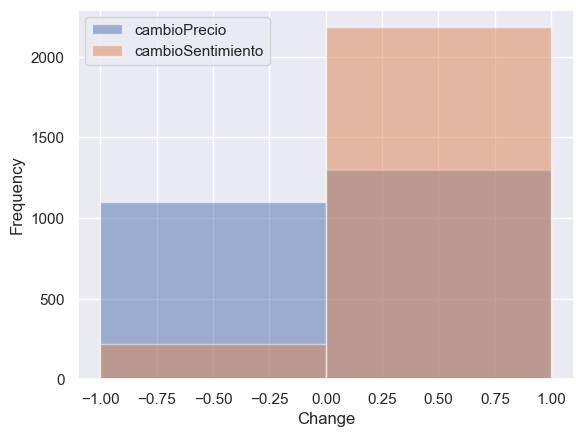

In [65]:
df_change = df_rw2[['cambioPrecio', 'cambioSentimiento']]
df_change.plot.hist(alpha=0.5, bins=2)
plt.xlabel('Change')
plt.ylabel('Frequency')
plt.show()

 + Aquí podemos observar que hay una gran diferencia de valores positivos frente a los negativos del sentimiento de twitter sobre BTC. A diferencia del precio de BTC que como es lógico es mas o menos equitativo, siendo mayor el positivo ya que el BTC creció de valor desde 2013 a 2019.


C:\Users\Carlow\AppData\Roaming\Python\Python39\site-packages\matplotlib\collections.py:967: RuntimeWarning:

invalid value encountered in sqrt



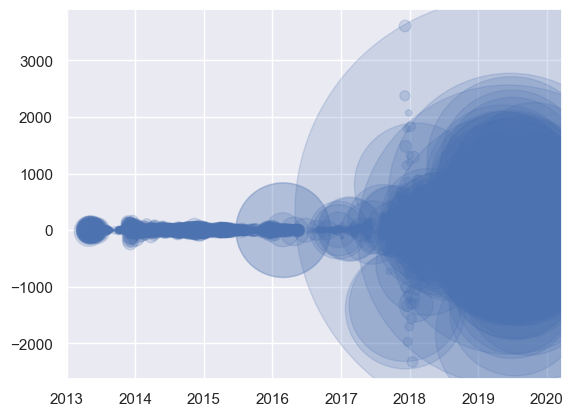

In [66]:
plt.scatter(x = df_rw2['Date'], y = df_rw2['valor_precio'], s = df_rw2['sentimiento'], alpha = .2)

 + El eje Y reprenta la variación del precio, es decir, burbujas que estén arriba son que ha habido una gran variación de precio positiva, y en la parte baja, negativa.
 + El eje X representa el valor dle tiempo.
 + Por último las burbujas representan el sentimiento en cada uno de los días.
 + Este gráfico de burbujas se parece mucho al que vimos de líneas del precio frente al sentimiento, ya que al principio habia algunos repuntes pero no influía en el precio, a diferencia de las fechas de 2018/2019 que podemos ver que hubo grandes fluctuaciones de precio por una gran cantidad de sentimiento.

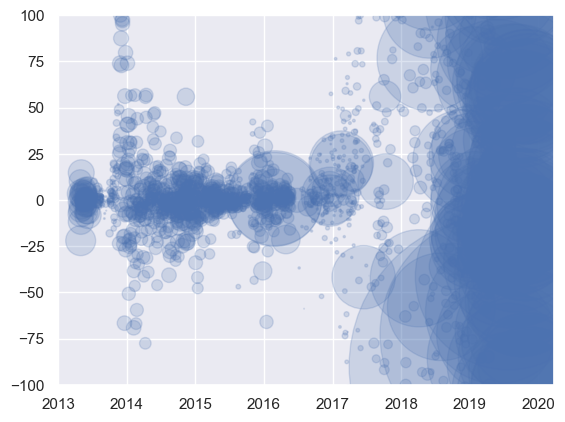

In [67]:
plt.ylim([-100,100])
plt.scatter(x = df_rw2['Date'], y = df_rw2['valor_precio'], s = df_rw2['sentimiento'], alpha = .2)

 + Nos gustaría observar el intervalo inicial del gráfico de burbujas por lo que hemos establecido un límite en el intervalo de variación de precio [-100, 100].
 + Aquí podemos observar que todo está muy concentrado ya que hay poca variación de precio, pero hay dispersión de datos tanto positiva como negativa. En la parte central podemos ver algo interesante, hay burbujas de gran tamaño que no están el centro y eso quiere decir que ha habido algunos momentos de variación de precio que tienen relación con el sentimiento positivo/negativo de twitter. Por lo que podemos decir que se relacionan.
 + Y por último una vez más podemos observar que en 2018/2019 ha habido mucho sentimiento y mucha variación de precio por lo que no cabe duda que están relacionados.